The data is huge and comes in a .tgz. We'll extract everything, then save off what we need.

In [1]:
import os, sys, tarfile

In [2]:
###############################
# https://www.yelp.com/dataset
###############################
# with tarfile.open('yelp_dataset.tgz', 'r:gz') as tar:
#     tar.extractall()

# Filtering Businesses

Here we filter down to just restaurants. This misses some that just have "food" or whatever as a category, but oh well.

In [3]:
import pandas as pd

businesses = pd.read_json('yelp_academic_dataset_business.json', lines=True)
businesses['Is_Restaurant'] = businesses.categories.str.contains('Restaurant')

In [4]:
businesses = businesses[businesses['Is_Restaurant'] == True]
businesses.groupby('city').agg({'review_count' : 'sum', 'stars': 'mean'}).sort_values(by='review_count', ascending=False).head(30)


,review_count,stars
city,,
Philadelphia,665749,3.556030
New Orleans,465988,3.744027
Nashville,318560,3.564323
Tampa,293130,3.603512
Indianapolis,242024,3.490566
Tucson,238902,3.462753
Reno,191056,3.576475
Saint Louis,171785,3.504746
Santa Barbara,158247,3.827901


Let's just look at NOLA for now.

In [5]:
businesses = businesses[businesses['city'] == 'New Orleans']

# Creating review files
We load in the reviews in chunks to avoid memory-related crashes.

In [6]:
import numpy as np
reviews = []

with open("yelp_academic_dataset_review.json", "r") as f:
    reader = pd.read_json(f, orient="records", lines=True, chunksize=1000)
        
    for chunk in reader:
        is_rest_review = chunk.business_id.isin(businesses.business_id)
        reduced_chunk = chunk[is_rest_review]
        reviews.append(reduced_chunk)
    
reviews = pd.concat(reviews, ignore_index=True)

We'll have to find some cutoff to determine usefulness, as most reviews seem to be not useful.

In [7]:
reviews['useful'].value_counts().head(20) / reviews.shape[0]

0     0.626405
1     0.198433
2     0.078969
3     0.037533
4     0.019317
5     0.011301
6     0.006996
7     0.004750
8     0.003488
9     0.002582
10    0.001939
11    0.001396
12    0.001226
13    0.000879
14    0.000777
15    0.000642
16    0.000504
17    0.000420
18    0.000353
19    0.000300
Name: useful, dtype: float64

# Tokenizing reviews

Here we create a function to tokenize the sentences, and remove non-alpha characters and newline calls.

In [8]:
import re
import string
from tqdm import trange
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def clean_and_split(s):
    # string.punctuation is a string with all the different punctuation symbols.
    # # ’tr’ is an object that will assign blank space to each punctuation symbol.
    tr=str.maketrans(string.punctuation," "*len(string.punctuation))
    s=s.lower().translate(tr)
    # replace \r\n
    s = re.sub('(\r\n)+',' ',s)
    s = re.sub('(\\n)+',' ',s)
    # replace \x95
    s = re.sub('[\x95\x97\u0097]',' ',s)
    s = re.sub('\s\d+', ' ', s)
    # replace whitespace substrings with one whitespace and remove leading/trailing whitespaces
    s = re.sub(' +',' ',s.strip())
    s=s.split(' ')
    # replace 
    
    return s


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yahms\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We both tokenize the sentences, and eliminate common stop words to get a sense of the significant vocabulary at large here.

In [9]:
reduced_text = []
word_cnt = []

for j in trange(reviews.shape[0]):
    words = clean_and_split(reviews['text'][j])
    word_cnt.append(len(words))
    
    words_red = [x for x in words if not x in STOPWORDS]
    reduced_text.append(words_red)

word_cnt = np.array(word_cnt)

100%|██████████| 476428/476428 [00:44<00:00, 10677.69it/s]


There are many short reviews -- I've shortened the review search to just 200-300 word count reviews.

32599


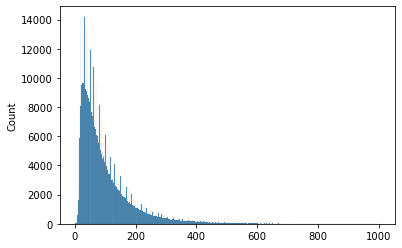

In [10]:
import seaborn as sns
sns.histplot(word_cnt)
print(np.sum((word_cnt > 200) & (word_cnt < 300)))

In [ ]:
ix_large_reviews = (word_cnt >= 200) & (word_cnt <=300)
reviews['reduced_text'] = reduced_text
reduced_reviews = reviews.iloc[ix_large_reviews].reset_index()

The next steps concatenate all cleaned reviews into one large corpus, and finds the frequencies of all words in said corpus. Notably, it only takes the 9 words for us to see that we are indeed looking at NOLA reviews.

In [12]:
corpus = reduced_reviews['reduced_text'][len(reduced_reviews)-1]
for j in trange(reduced_reviews.shape[0]-1):
    corpus[0:0] = reduced_text[j]

100%|██████████| 33336/33336 [00:11<00:00, 2890.49it/s] 


In [13]:
len(corpus)

1581590

In [14]:
v = nltk.FreqDist(corpus); v

FreqDist({'food': 21510, 'good': 18880, 'great': 16429, 'place': 15748, 'service': 12094, 'like': 8877, 'one': 8815, 'back': 8568, 'shrimp': 8453, 'time': 8146, ...})

In [15]:
words = set(v)
vocab = [word for word in words if not v[word] < 50]

In [16]:
len(vocab)

3112

Now we re-tokenize on the preprocessed data, filling in any words outside of the top 3000 with "<OOV>". For a real model we should probably keep stop words.

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 3000, oov_token = '<OOV>', split='')
tokenizer.fit_on_texts(reduced_reviews['reduced_text'].values)

In [18]:
X = tokenizer.texts_to_sequences(reduced_reviews['reduced_text'].iloc[:33336].values)
X = pad_sequences(X)

And we build a simple LSTM model

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

embed_dim = 128
lstm_out = 196
batch_size = 32

model = Sequential()
model.add(Embedding(3000, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout = 0.2))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 260, 128)          384000    
                                                                 
 dropout_2 (Dropout)         (None, 260, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 5)                 985       
                                                                 
Total params: 639,785
Trainable params: 639,785
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
Y = pd.get_dummies(reduced_reviews['stars'][:33336]).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 414)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(25002, 260) (25002, 5)
(8334, 260) (8334, 5)


In [39]:
model.fit(X_train, Y_train, batch_size = batch_size, verbose = 2)


score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))




782/782 - 18s - loss: 0.9516 - accuracy: 0.5785 - 18s/epoch - 23ms/step
261/261 - 4s - loss: 0.9780 - accuracy: 0.5644 - 4s/epoch - 14ms/step
Score: 0.98
Validation Accuracy: 0.56


0.9779956936836243